In [1]:
from imutils import paths
import numpy as np
import argparse
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential
from torch.optim import Adam
from torchvision import models

plt.ion()   # interactive mode


### Loading the training image 

In [2]:
from torchvision import datasets, models, transforms


In [3]:
data_dir = 'dataset'

In [3]:
from torchvision import transforms


In [4]:
from torchvision import transforms
data_transforms = {
'train' : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
}

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val']}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


In [7]:
dataset_sizes

{'train': 1236, 'val': 140}

In [8]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1236
     Root location: dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 140
     Root location: dataset/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [9]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [10]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8fdfc05e48>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f8fdfc05ef0>}

In [11]:
image_datasets['train'].classes

['with_mask', 'without_mask']

In [12]:
class_names = image_datasets['train'].classes

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [14]:
device

device(type='cpu')

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


In [16]:
classes

tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0])

In [17]:
inputs.shape

torch.Size([32, 3, 224, 224])

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [5]:
import torchvision

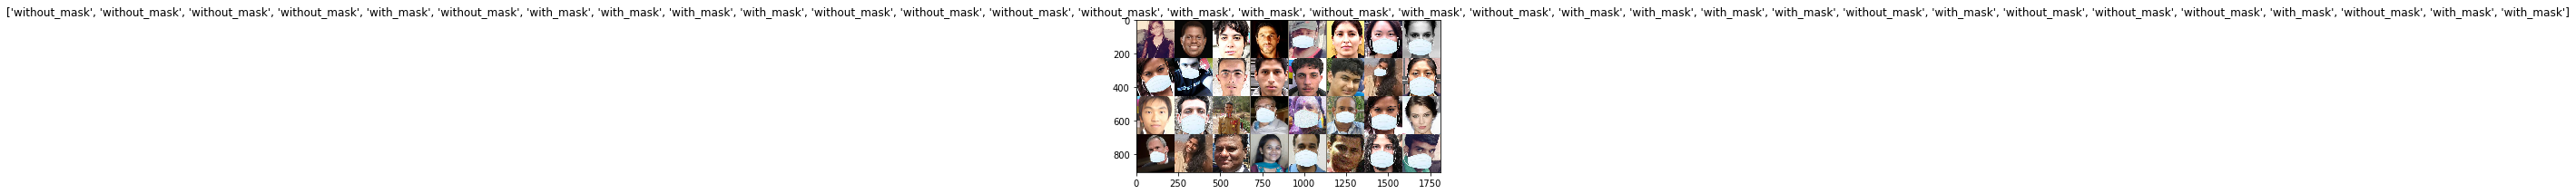

In [20]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

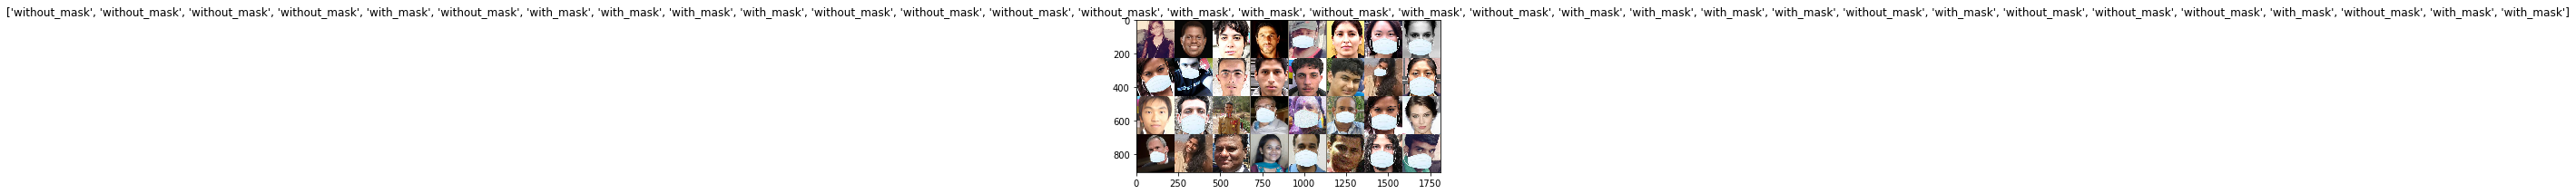

In [21]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
# # number of neurons in each layer
# input_num_units = 28*28
# hidden_num_units = 500
# output_num_units = 10

# set remaining variables
epochs = 20
learning_rate = 0.0004

In [25]:
# model = models.MobileNetV2()
# # loss function
# loss_fn = CrossEntropyLoss()

# # define optimization algorithm
# optimizer = Adam(model.parameters(), lr=learning_rate)

In [26]:
# model.state_dict

In [27]:
# model_ft = models.resnet18(pretrained=False)


In [28]:
# model_ft.state_dict

In [29]:
# model_ft.classifier.

In [27]:
from torch.optim import lr_scheduler


In [31]:
model_ft = models.MobileNetV2()
model_ft.classifier[1] = torch.nn.Linear(1280, 2)
# num_ftrs = model_ft.criterion.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
import time

In [33]:
import copy

In [34]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6858 Acc: 0.5550
val Loss: 0.7464 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.4067 Acc: 0.8471
val Loss: 1.2034 Acc: 0.5000

Epoch 2/24
----------
train Loss: 0.1496 Acc: 0.9579
val Loss: 0.2663 Acc: 0.8714

Epoch 3/24
----------
train Loss: 0.0617 Acc: 0.9887
val Loss: 0.3398 Acc: 0.8071

Epoch 4/24
----------
train Loss: 0.0485 Acc: 0.9887
val Loss: 0.2171 Acc: 0.8929

Epoch 5/24
----------
train Loss: 0.0299 Acc: 0.9919
val Loss: 0.0646 Acc: 0.9714

Epoch 6/24
----------
train Loss: 0.0269 Acc: 0.9919
val Loss: 0.0972 Acc: 0.9714

Epoch 7/24
----------
train Loss: 0.0236 Acc: 0.9951
val Loss: 0.1061 Acc: 0.9714

Epoch 8/24
----------
train Loss: 0.0184 Acc: 0.9968
val Loss: 0.1332 Acc: 0.9714

Epoch 9/24
----------
train Loss: 0.0155 Acc: 0.9968
val Loss: 0.1141 Acc: 0.9714

Epoch 10/24
----------
train Loss: 0.0097 Acc: 1.0000
val Loss: 0.0886 Acc: 0.9714

Epoch 11/24
----------
train Loss: 0.0143 Acc: 0.9984
val Loss: 0.0969 Acc: 0.9714

Ep

In [35]:
torch.save(model_ft, 'mobile_netv2')

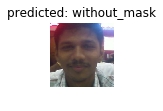

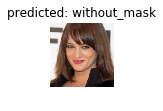

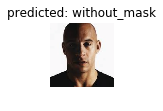

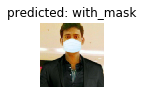

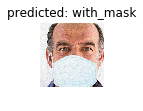

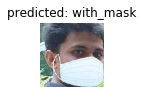

In [36]:
visualize_model(model_ft)


In [37]:
model_ft.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [6]:
class_names = ['with_mask', 'without_mask']

In [8]:
model_ft = torch.load('mobile_netv2')

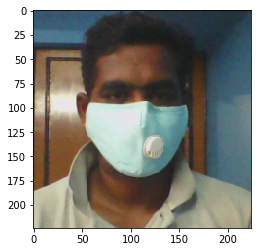

torch.Size([1, 3, 224, 224])
 Prediction = with_mask


In [9]:
from PIL import Image

loader = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image = Image.open('examples/test11.jpg')
x = loader(image)
img = x
imshow(x, '')
x.unsqueeze_(0)
print(x.shape)

model_ft.eval()
outputs = model_ft.forward(x)
_, preds = outputs.max(1)
print(" Prediction = " + class_names[preds.item()])

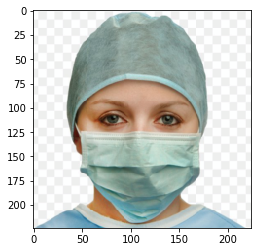

 Prediction =  with_mask


In [10]:
from PIL import Image

loader = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image = Image.open('examples/test2.jpeg')
x = loader(image)
imshow(x, '')
x.unsqueeze_(0)
# print(x.shape)

model_ft.eval()
outputs = model_ft.forward(x)
_, preds = outputs.max(1)
print(" Prediction = ", class_names[preds.item()])


In [39]:
preds

tensor([0])

In [20]:
image = Image.open('examples/test12.jpg')
x = loader(image)


In [59]:
preds.item()

0

In [87]:
def imshow_1(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [32]:
prototxtPath = os.path.sep.join(['face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join(['face_detector',
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)


In [33]:
image = cv2.imread('examples/test12.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

In [34]:
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))


In [35]:
net.setInput(blob)
detections = net.forward()

In [36]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

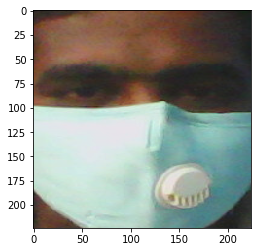

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
with_mask


In [38]:
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]

    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (256, 256))
        #fac = Image.array_to_img(face)
#         imshow(fac, '')
        img2 = Image.fromarray(face)
        x = loader(img2)
        imshow(x, '')
#         im2 = Image.fromarray(face)
        
#         face = img_to_array(face)
#         face = preprocess_input(face)
        print(x.shape)
        face =  x.unsqueeze_(0)
#         face = np.expand_dims(face, axis=0)
#         print(face.shape)
#         face.trans
        
        print(face.shape)
#         im2 = Image.fromarray(face)
# #         cv2.imshow('Test', face)
#         im2 = loader(im2)
        
#         im2.unsqueeze_(0)
        # print(x.shape)
#         face = torch.from_numpy(face)

        model_ft.eval()
        outputs = model_ft.forward(face)
        _, preds = outputs.max(1)
        print(class_names[preds.item()])


In [3]:
import pandas as pd

In [16]:
epoch_detail = pd.read_csv('epoch_detail.csv')

In [17]:
epoch_detail.columns

Index(['epoch', 'training loss', 'training accuracy', 'validation loss',
       'validation accuracy'],
      dtype='object')

In [18]:
train_losses = epoch_detail['training loss']
val_losses = epoch_detail['validation loss']

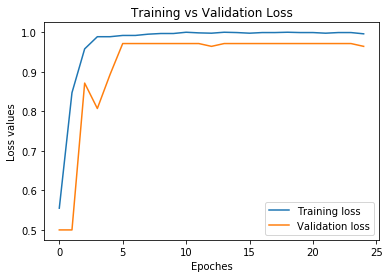

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss values')
plt.show()


In [20]:
train_losses = epoch_detail['training accuracy']
val_losses = epoch_detail['validation accuracy']

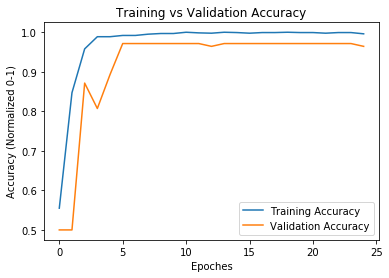

In [22]:
plt.plot(train_losses, label='Training Accuracy')
plt.plot(val_losses, label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy (Normalized 0-1)')
plt.show()

In [39]:
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

In [45]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > args["confidence"]:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            img2 = Image.fromarray(face)
            x = loader(img2)
#             face = img_to_array(face)
#             face = preprocess_input(face)
#             face = np.expand_dims(face, axis=0)

            # add the face and bounding boxes to their respective
            # lists
            face_1 =  x.unsqueeze_(0)
            faces.append(face_1)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        outputs = model_ft.forward(faces)
        _, preds = outputs.max(1)
        print(class_names[preds.item()])
#         preds = maskNet.predict(faces)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

In [48]:
import cv2



# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([ 'face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join([ 'face_detector',
	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = None #load_model(args["model"])

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs.stop()
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] starting video stream...


AttributeError: 'NoneType' object has no attribute 'shape'

In [49]:
vs.stop()

In [50]:
vs = VideoStream(src=0).start()


In [51]:
vs

In [52]:
vs.stop()